In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import sys
from pathlib import Path

parent = Path.cwd().parent
sys.path.insert(0, str(parent))

from helpers.data_cleaners import summary_stats, snake_cols 
from helpers.data_eda import remove_outliers_by_zscore
from helpers.unsupervised import pca_recommendation_viz

# Overview

Last session, we went through data cleaning and EDA. This session we're covering Clustering and PCA.

When would you use Clustering and PCA?
1. When you have a large dataset and need to reduce the no. of features
2. When you believe there is a lot of noise within the features and want to extract what's important
3. When you want to create new features to add to your existing features
4. When you're bored and have no idea what's in the dataset, this might be a way of looking busy at work =)


## Load Data
Assignment 6.3

In [4]:
df = pd.read_csv('../datasets/marketing_campaign.csv', sep = '\t')

## Data Cleaning & EDA

In [5]:
df=snake_cols(df)

### Drop Columns (initial)

Use summary_stats and look for columns that are all unique (too much variation) and not unique at all (no variation)

In [622]:
summary_stats(df)

,dtype,sample_val,vals,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
id,int64,5692,2240,0.0,2240,5592.16,0.0,0.0,11191.0,3246.66,0.0,-1.2
year_birth,int64,1969,2240,0.0,59,1968.81,1976.0,1893.0,1996.0,11.98,-0.3,0.7
education,object,Graduation,2240,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,object,Together,2240,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,float64,35388.0,2216,1.1,1974,52247.25,7500.0,1730.0,666666.0,25173.08,6.8,159.6
kidhome,int64,0,2240,0.0,3,0.44,0.0,0.0,2.0,0.54,0.6,-0.8
teenhome,int64,0,2240,0.0,3,0.51,0.0,0.0,2.0,0.54,0.4,-1.0
dt_customer,object,15-09-2012,2240,0.0,663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recency,int64,93,2240,0.0,100,49.11,56.0,0.0,99.0,28.96,-0.0,-1.2
mnt_wines,int64,2,2240,0.0,776,303.94,2.0,0.0,1493.0,336.60,1.2,0.6


In [6]:
df.drop(columns=["z_cost_contact", "z_revenue", "id"], inplace=True)


### Missing Data
Analyse first to understand if there is a pattern in what's missing i.e. not MCAR (missing completely at random)


In [7]:
#df[df['income'].isnull()]
# looks MCAR, not that many (26 rows out of 2240) so proceed to drop
df = df.dropna()

### Outlier Detection
Again, during EDA we want to drop the noise as much as possible. We're interested in continuous numerical data that is beyond what we consider 'normal'.

Z-score is a standardized value that tells you how many standard deviations a data point is from the mean.

Use remove_outlier_by_zscore to drop rows for columns you think are interesting features (default z score of 3)



In [ ]:
columns_of_interest = ['income', 'year_birth']

for col in columns_of_interest:
    print(f"{col}: {df[col].value_counts().sort_index().to_dict()}")

income: {1730.0: 1, 2447.0: 1, 3502.0: 1, 4023.0: 1, 4428.0: 1, 4861.0: 1, 5305.0: 1, 5648.0: 1, 6560.0: 1, 6835.0: 1, 7144.0: 1, 7500.0: 12, 8028.0: 1, 8820.0: 1, 8940.0: 1, 9255.0: 1, 9548.0: 1, 9722.0: 1, 10245.0: 1, 10404.0: 1, 10979.0: 2, 11012.0: 1, 11448.0: 1, 12393.0: 1, 12571.0: 1, 13084.0: 1, 13260.0: 1, 13533.0: 1, 13624.0: 1, 13672.0: 1, 13724.0: 1, 14045.0: 1, 14188.0: 1, 14421.0: 1, 14515.0: 1, 14661.0: 1, 14796.0: 1, 14849.0: 1, 14906.0: 1, 14918.0: 1, 15033.0: 1, 15038.0: 1, 15056.0: 1, 15072.0: 1, 15253.0: 1, 15287.0: 2, 15315.0: 2, 15345.0: 1, 15716.0: 1, 15759.0: 1, 15862.0: 1, 16005.0: 1, 16014.0: 1, 16185.0: 1, 16248.0: 1, 16269.0: 1, 16529.0: 1, 16531.0: 1, 16581.0: 1, 16626.0: 1, 16653.0: 1, 16813.0: 1, 16860.0: 1, 16927.0: 1, 17003.0: 1, 17117.0: 1, 17144.0: 2, 17148.0: 1, 17256.0: 1, 17323.0: 1, 17345.0: 1, 17459.0: 1, 17487.0: 1, 17649.0: 1, 17688.0: 1, 18100.0: 1, 18169.0: 1, 18222.0: 1, 18227.0: 1, 18351.0: 1, 18358.0: 1, 18393.0: 1, 18492.0: 1, 18589.0: 1, 

In [8]:
df = remove_outliers_by_zscore(df, columns=['income', 'year_birth'])

Checking for outliers in columns: ['income', 'year_birth']
Removed 11 outlier rows (0.5%)


## PCA

Essentially, you're just creating new features from your existing ones (features with ~continuous numerical data values), but these are:
- linear combinations of the original features
- uncorrelated (independent) of one another

Key Assumption 1! You suspect non-linear relationships between features - if you don't think so then manifold learning techniques may be more appropriate.

Key Assumption 2! Your features with linear relationships are continuous numerical data values (think: 'measured', like time). PCA also works fine on discrete numerical (purchases per month, no. of children etc.) as they're still quantitative.

### Alternatives

PCA on mixed data (not discrete/continuos numerical) is ok to use in practise. At the end of the day, what matters is your model performance. 

Other approaches you could use (dataset-level):
1. MIXED Data (continuous + categorical) --> convert categorical into numerical using 'One-hot encoding'
2. MIXED Data (continuous + categorical) --> Factor Analysis of Mixed Data (FAMD)
3. Categorical Data ONLY --> Multiple Correspondence Analysis (MCA)

Other approaches you could use (algo-level):
1. Dimensionality Reduction (non-linear) --> t-SNE - handles mixed data better OR UMAP (faster than t-SNE)

My personal preference: keep categorical and binned/group variables out of PCA. 

### Feature Engineering for PCA

We have a time value, but not in a format we can use for PCA. Let's extract year, month, day as separate numeric columns.

In [9]:
df['dt_customer'] = pd.to_datetime(df['dt_customer'], format='%d-%m-%Y')

df['year'] = df['dt_customer'].dt.year
df['month'] = df['dt_customer'].dt.month
df['day'] = df['dt_customer'].dt.day
df.drop(columns=['dt_customer'], inplace=True)

Lets separate out category and other binned/group features

In [10]:
cols_category = ['education', 'marital_status','kidhome','teenhome','accepted_cmp3',
       'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1', 'accepted_cmp2',
       'complain', 'response']

# df we will use for PCA
df_pca = df.drop(columns=cols_category)


In [11]:
summary_stats(df_pca)

,dtype,sample_val,vals,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
year_birth,int64,1977.0,2205,0.0,56,1968.90,1976.0,1940.0,1996.0,11.71,-0.1,-0.8
income,float64,31878.0,2205,0.0,1963,51622.09,7500.0,1730.0,113734.0,20713.06,0.0,-0.8
recency,int64,42.0,2205,0.0,100,49.01,56.0,0.0,99.0,28.93,-0.0,-1.2
mnt_wines,int64,41.0,2205,0.0,775,306.16,2.0,0.0,1493.0,337.49,1.2,0.6
mnt_fruits,int64,53.0,2205,0.0,158,26.40,0.0,0.0,199.0,39.78,2.1,4.1
mnt_meat_products,int64,27.0,2205,0.0,551,165.31,7.0,0.0,1725.0,217.78,1.8,3.2
mnt_fish_products,int64,0.0,2205,0.0,182,37.76,0.0,0.0,259.0,54.82,1.9,3.1
mnt_sweet_products,int64,40.0,2205,0.0,176,27.13,0.0,0.0,262.0,41.13,2.1,4.1
mnt_gold_prods,int64,35.0,2205,0.0,212,44.06,3.0,0.0,321.0,51.74,1.8,3.1
num_deals_purchases,int64,3.0,2205,0.0,15,2.32,1.0,0.0,15.0,1.89,2.3,8.2


### PCA Analysis
PCA is not a panacea. You need to analyse and interpret the results to decide whether to use PCA, augment your dataset with PCs, or simply keep your original features.

Use the following:
- Scree plots: helps you see how much variance (of the total dataset) each PC captures
- PC v. Feature: heatmaps can look at the correlation between your first few PCs and your features

Remember: scale, scale, scale!

Use this helper pca_recommendation_viz to generate a scree plot, heatmap, and recommendations

#### Scree plots
Scree plots are a way of seeing how much of your dataset's total variance can be captured by each principal component. 
- If the first few PCs capture >80-90% variance, PCA is very effective!
- If you need almost as many PCs as you have features, you probably don't need PCA as it's already effective
- If you see a nice spike in the first couple of PCs, consider adding them as new features to your existing dataset

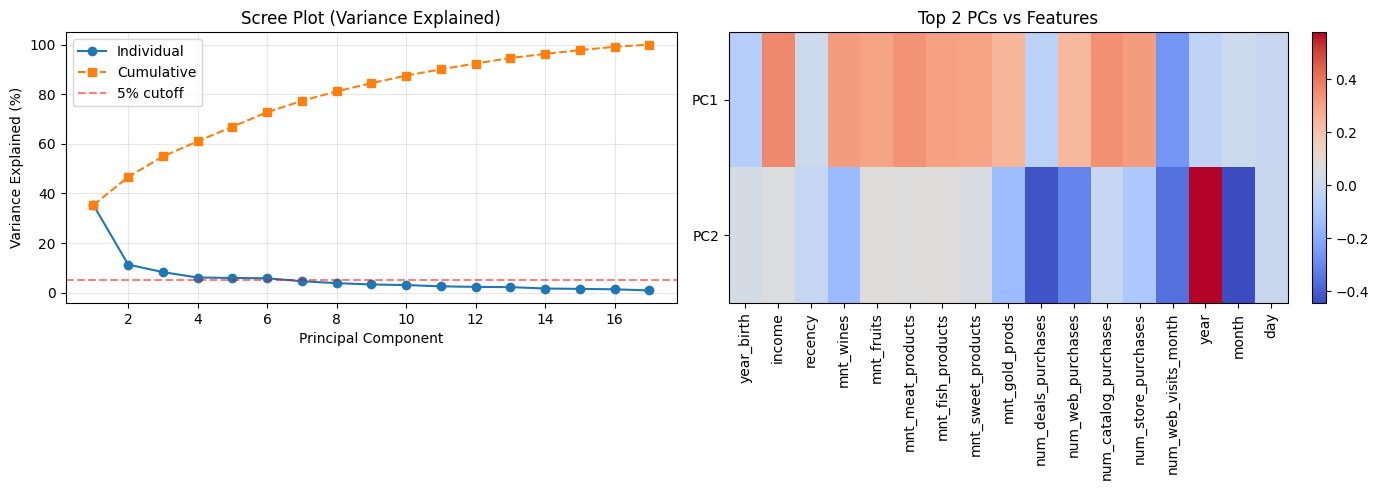

,Metric,Value
0,Total Variance Explained,100.0%
1,PCs for 80% Variance,8
2,PCs for 95% Variance,14
3,Strong PCs (>5% var each),6
4,Recommendation,Add <=8 PCs as new features only.


In [14]:
pca_analysis = pca_recommendation_viz(df_pca, top_n_pc=2)
pca_analysis

### PCA Intepretation
When <80% variance is explained by a small number of PCs, it means:
- The variance is spread out across many features (i.e. your data is not highly correlated).
- PCA may not help that much for dimensionality reduction

Pro tip: but it may still produce a few orthogonal features (PCs) that capture latent components --> which can still help your model performance!

How many PCs to create as new features?
Look at the scree plot, you have a couple of options:
1. The elbow point is where the marginal gain in variance sharply drops — i.e. where adding more PCs yields diminishing returns, OR
2. 5% cutoff line: which principal components each explain more than 5% of total variance?

Personally, I choose somewhere in the middle.

## PCA and Clusters as features

### Scaling
Get into the habit of just always scaling. 

Scaling the data ensures that each variable contributes equally to the analysis, preventing variables with larger scales from disproportionately influencing the result.

Variables measured in different units (e.g., kilograms, kilometers, etc.) should not influence the analysis based on their unit magnitude.

Most models you will use need scaled data...and even those that don't need it (like Decision Trees, Random Forests etc.) it won't even impact the model if you do.

**Note: You should scale X (features) and y (target) SEPARATELY, and in most cases, you DON'T scale y at all.**

In [16]:
# Remember: always scale before using unsupervised learning techniques like PCA
scaler = StandardScaler().fit(df_pca)
scaled_df_pca = scaler.transform(df_pca)

### PCA Features

In [17]:
# Fit PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(scaled_df_pca)

### Clustering Features

IF you don’t know no. of clusters there are AND don’t need all data points clustered/grouped THEN you can probably use DBScan. Obviously, you can use others like K-means too. 

In [18]:
# Run DBSCAN
dbscan = DBSCAN(eps=2, min_samples=8)
cluster_dbscan = dbscan.fit_predict(scaled_df_pca)

### Add features

In [19]:
# Create a new df --> add PCs
unsuper_learning_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=df.index)

# Add cluster to new df
unsuper_learning_df['cluster'] = cluster_dbscan

In [20]:
# combine into one
df = pd.concat([df, unsuper_learning_df], axis=1)

In [21]:
summary_stats(df)

,dtype,sample_val,vals,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
year_birth,int64,1955,2205,0.0,56,1968.90,1976.00,1940.00,1996.00,11.71,-0.1,-0.8
education,object,PhD,2205,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,object,Married,2205,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,float64,37697.0,2205,0.0,1963,51622.09,7500.00,1730.00,113734.00,20713.06,0.0,-0.8
kidhome,int64,0,2205,0.0,3,0.44,0.00,0.00,2.00,0.54,0.6,-0.8
teenhome,int64,0,2205,0.0,3,0.51,0.00,0.00,2.00,0.54,0.4,-1.0
recency,int64,2,2205,0.0,100,49.01,56.00,0.00,99.00,28.93,-0.0,-1.2
mnt_wines,int64,984,2205,0.0,775,306.16,2.00,0.00,1493.00,337.49,1.2,0.6
mnt_fruits,int64,10,2205,0.0,158,26.40,0.00,0.00,199.00,39.78,2.1,4.1
mnt_meat_products,int64,44,2205,0.0,551,165.31,7.00,0.00,1725.00,217.78,1.8,3.2


## Summary
You are close to now choosing and running a model!

What did we achieve?
1. EDA revealed columns to drop (too unique or not unique) and rows to drop (missing or outliers)
2. Added new 'time' features through Feature Engineering
3. Analysed numerical features using PCA (scaling first)
4. PCA interpretation led to addition of 2 new PC features to our dataset
5. An additional clustering feature (DBScan) was added to our dataset


...to the future!

To dos (before we can run a model)
1. Scale numerical features: scale numerical features within the dataset (we only did this for PCA)
2. Encode categorical features: review categorical + remaining features (ordinal?) to determine encoding requirements
   1. Encoding method will depend on feature (categorical v. ordinal) and the model i.e. IF categorical AND model = Logistic Regression THEN use one-hot encoding, IF categorical AND model = Decision Tree THEN use simple mapping